# Quantum Teleportation

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state  |ψ⟩=α|0⟩+β|1⟩ . This entails passing on information about  α  and  β  to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of  |ψ⟩  and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state  |ψ⟩  to Bob. We call this teleportation because, at the end, Bob will have  |ψ⟩  and Alice won't anymore.


To transfer a quantum bit, Alice and Bob must use a third party (Telamon) to send them an entangled qubit pair. Alice then performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.



<img src="tele1.jpg" width="500"/>

In [1]:

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ,Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex


In [2]:
#Create a circuit
qr = QuantumRegister(3)    # Protocol uses 3 qubits
crz = ClassicalRegister(1) # and 2 classical bits
crx = ClassicalRegister(1) # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

A third party, Telamon, creates an entangled pair of qubits and gives one to Bob and one to Alice.

The pair Telamon creates is a special pair called a Bell pair using a Hadamard gate, and then to apply a CNOT gate.

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

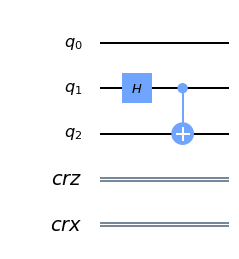

In [4]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3,name='q')
crz, crx = ClassicalRegister(1,name='crz'),ClassicalRegister(1,name='crx')
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw('mpl')

What happened till now? 

Telamon created a Bell pair using q1 and q2. 

------------------------

Let's say Alice owns  q1  and Bob owns  q2  after they part ways.

Step 2:

Alice applies a CNOT gate to  q1 , controlled by  |ψ⟩  (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to  |ψ⟩ . In our quantum circuit, the qubit ( |ψ⟩ ) Alice is trying to send is  q0 :

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

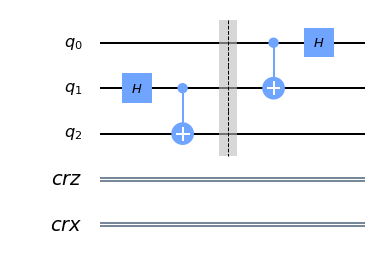

In [6]:
## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output='mpl')

Step 3 

Next, Alice applies a measurement to both qubits that she owns,  q1  and  |ψ⟩ , and stores this result in two classical bits. She then sends these two bits to Bob.

In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

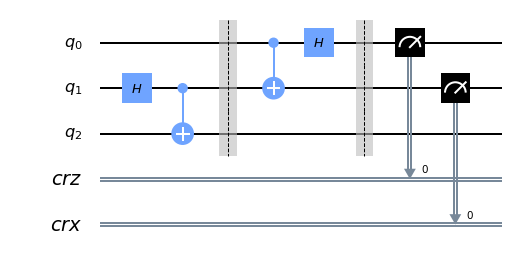

In [8]:
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw('mpl')

Bob, who already has the qubit  q2 , then applies the following gates depending on the state of the classical bits:

00  →  Do nothing

01  →  Apply  X  gate

10  →  Apply  Z  gate

11  →  Apply  ZX  gate

In [9]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

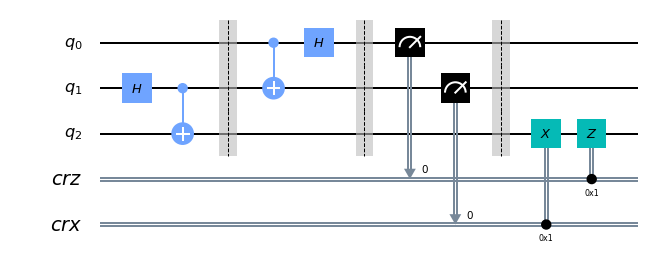

In [10]:
## STEP 4
## Complete Circuit Again
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw('mpl')

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

# Example: 

In [20]:
psi=random_state(1)
array_to_latex(psi, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

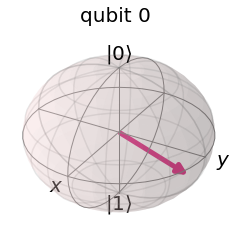

In [21]:
plot_bloch_multivector(psi)

In [22]:
#Create initialization gate to create psi from |0>
init_gate=Initialize(psi)
init_gate.label='init'

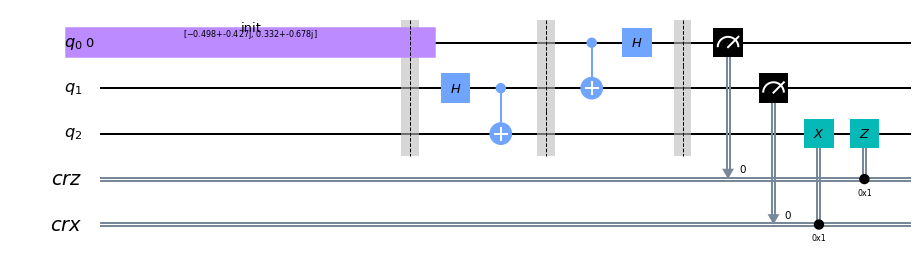

In [23]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw('mpl')

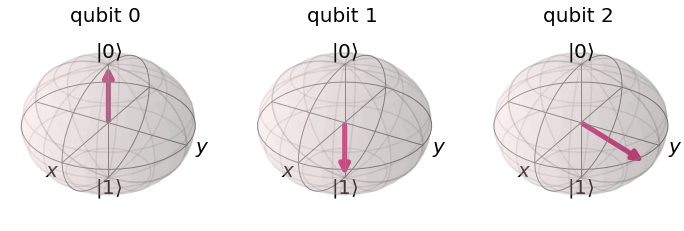

In [24]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

We can see above, using our statevector simulator, that the state of  |q2⟩  is the same as the state  |ψ⟩  we created above, while the states of  |q0⟩  and  |q1⟩  have been collapsed to either  |0⟩  or  |1⟩ . The state  |ψ⟩  has been teleported from qubit 0 to qubit 2.

## Doing in a Real Quantum Computer

But "Statevector Simulator" is only theory.
Let's see how it will work on real quantum computer.

On a real quantum computer, we would not be able to sample the statevector, so if we wanted to check our teleportation circuit is working, we need to do things slightly differently. You will remember that we used Initialize to turn our  |0⟩  qubit into the state  |ψ⟩ :

$|0\rangle \xrightarrow{\text{Initialize}} |\psi\rangle$

Since all quantum gates are reversible, we can find the inverse of Initialize using:

In [16]:
inverse_init_gate = init_gate.gates_to_uncompute()

To prove the qubit  |q0⟩  has been teleported to  |q2⟩ , if we do this inverse initialization on  |q2⟩ , we expect to measure  |0⟩  with certainty. We do this in the circuit below:

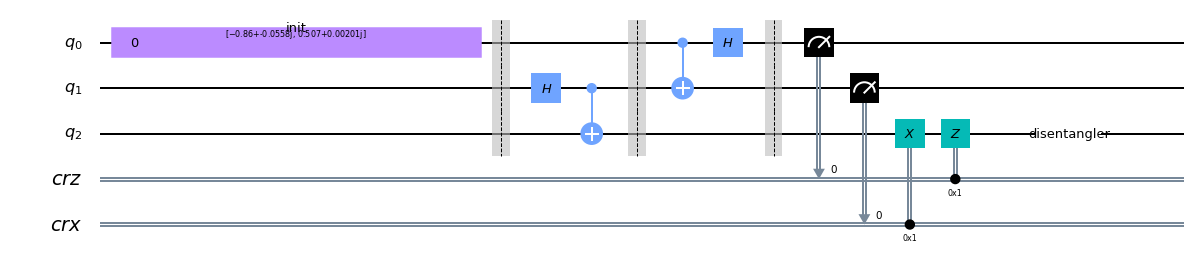

In [17]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw('mpl')

Finally, we measure the third qubit and store the result in the third classical bit:

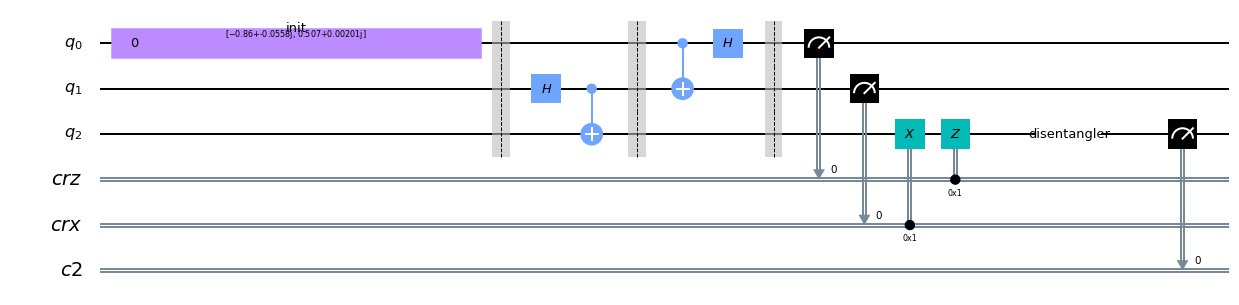

In [18]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw('mpl')

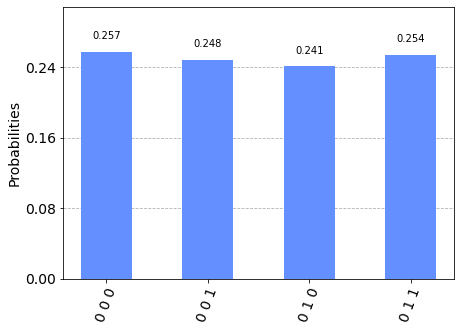

In [19]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

 We can see we have a 100% chance of measuring  q2  (the leftmost bit in the string) in the state  |0⟩ . This is the expected result, and indicates the teleportation protocol has worked properly.



# Let's do Some Math :) 

Step 1:

Quantum Teleportation begins with the fact that Alice needs to transmit  |q⟩=a|0⟩+b|1⟩  (a random qubit) to Bob. She doesn't know the state of the qubit. For this, Alice and Bob take the help of a third party (Telamon). Telamon prepares a pair of entangled qubits for Alice and Bob. The entangled qubits could be written in Dirac Notation as:

$|\psi \rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$
 
Alice and Bob each possess one qubit of the entangled pair (denoted as A and B respectively),

$|\psi\rangle = \frac{1}{\sqrt{2}} (|0\rangle_A |0\rangle_B + |1\rangle_A |1\rangle_B)$
 
This creates a three qubit quantum system where Alice has the first two qubits and Bob the last one.

$\begin{align*}
|q\rangle \otimes |\psi\rangle &= \frac{1}{\sqrt{2}} (a |0\rangle \otimes (|00\rangle + |11\rangle) + b |1\rangle \otimes (|00\rangle + |11\rangle))\\
&= \frac{1}{\sqrt{2}} (a|000\rangle + a|011\rangle + b|100\rangle + b|111\rangle) 
\end{align*}$

Step 2 

Now according to the protocol Alice applies CNOT gate on her two qubits followed by Hadamard gate on the first qubit. This results in the state:

$\begin{align*} (H \otimes I \otimes I) (CNOT \otimes I) (|q\rangle \otimes |\psi\rangle)
&=(H \otimes I \otimes I) (CNOT \otimes I) \frac{1}{\sqrt{2}} (a|000\rangle + a|011\rangle + b|100\rangle + b|111\rangle) \\
&= (H \otimes I \otimes I) \frac{1}{\sqrt{2}} (a|000\rangle + a|011\rangle + b|110\rangle + b|101\rangle) \\
&= \frac{1}{2}  (a(|000\rangle + |011\rangle + |100\rangle + |111\rangle) + b(|010\rangle + |001\rangle - |110\rangle - |101\rangle)) \\
\end{align*}$
 
Which can then be separated and written as:

$\begin{align*}
= \frac{1}{2}(
 & \phantom{+} |00\rangle (a|0\rangle + b|1\rangle) \hphantom{\quad )} \\
 & + |01\rangle (a|1\rangle + b|0\rangle) \hphantom{\quad )}\\[4pt]
 & + |10\rangle (a|0\rangle - b|1\rangle) \hphantom{\quad )}\\[4pt]
 & + |11\rangle (a|1\rangle - b|0\rangle) \quad )\\
\end{align*}$

Step 3 

Alice measures the first two qubit (which she owns) and sends them as two classical bits to Bob. The result she obtains is always one of the four standard basis states  |00⟩,|01⟩,|10⟩,  and  |11⟩  with equal probability.

On the basis of her measurement, Bob's state will be projected to,
$|00\rangle \rightarrow (a|0\rangle + b|1\rangle)\\
|01\rangle \rightarrow (a|1\rangle + b|0\rangle)\\
|10\rangle \rightarrow (a|0\rangle - b|1\rangle)\\
|11\rangle \rightarrow (a|1\rangle - b|0\rangle)$

Step 4 

Bob, on receiving the bits from Alice, knows he can obtain the original state  |q⟩  by applying appropriate transformations on his qubit that was once part of the entangled pair.

The transformations he needs to apply are:

<img src="teleportation-transformation.png" width="300" height='100'/>

After this step Bob will have successfully reconstructed Alice's state.

